In [1]:
import random
import numpy as np
import zstandard
import networkx as nx
import copy
import osmnx as ox

import random
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import subprocess
import ast
import sys


In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import utils as ut

In [3]:
place = 'Piedmont, California, USA'
g = ut.get_nx_from_ox(place)
wgt = 'length'

G = ox.graph_from_place(place, network_type='drive')

In [4]:
st_pairs = 100 

In [5]:
st = ut.sample_st(g,st_pairs, seed = 116)

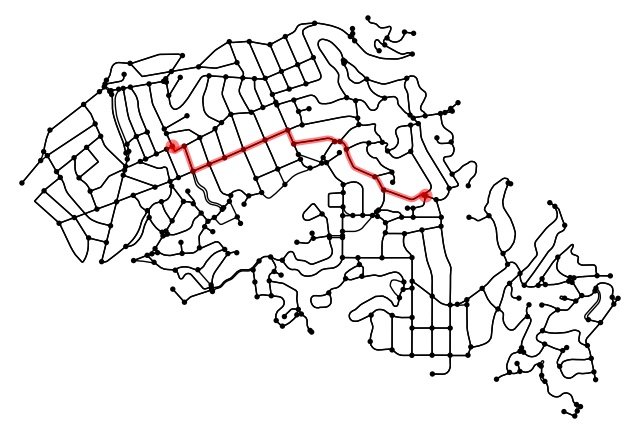

In [6]:
orig_node,dest_node = st[0][1],st[1][1]
route = nx.shortest_path(g, orig_node, dest_node, weight='length',method='dijkstra')
fig, ax = ox.plot_graph_route(G, route, bgcolor='white', edge_color='black', node_color='black')

In [7]:
folder_path = "/Users/antonioferrara/Desktop/GitHub/Maxmin-Fair-Paths/kspwlo-master/"
os.chdir(folder_path)
node_map = ut.save_graph_to_gr(g, 'tmp.gr', source=orig_node, target=dest_node,weight = wgt)
EKSP_node_map = ut.save_graph_to_gr_EKSP(g, 'tmp_EKSP.gr', source=orig_node, target=dest_node,weight = wgt)


In [8]:
with open('tmpQ.txt', 'w') as file:
    file.write(f"{EKSP_node_map[orig_node]} {EKSP_node_map[dest_node]}\n")

In [10]:
import numpy as np
from contextlib import contextmanager
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import time  # Import time module

# Initialize lists to store the results and runtimes
results_FP_paths = []
results_random_FP_paths = []
results_yen_k_shortest_10 = []
#results_yen_k_shortest_100 = []
results_kspwlo_paths_08_10 = []
results_kspwlo_paths_08_100 = []
results_kspwlo_paths_05_10 = []
results_kspwlo_paths_05_100 = []
results_opplus_paths_08_10 = []
results_opplus_paths_05_10 = []
results_EKSP_paths_05_10 = []


lengths_FP_paths = []
lengths_random_FP_paths = []
lengths_yen_k_shortest_10 = []
#lengths_yen_k_shortest_100 = []
lengths_kspwlo_paths_08_10 = []
lengths_kspwlo_paths_08_100 = []
lengths_kspwlo_paths_05_10 = []
lengths_kspwlo_paths_05_100 = []
lengths_opplus_paths_08_10 = []
lengths_opplus_paths_05_10 = []
lengths_EKSP_paths_05_10 = []


runtimes_FP_paths = []
runtimes_random_FP_paths = []
runtimes_yen_k_shortest_10 = []
#runtimes_yen_k_shortest_100 = []
runtimes_kspwlo_paths_08_10 = []
runtimes_kspwlo_paths_08_100 = []
runtimes_kspwlo_paths_05_10 = []
runtimes_kspwlo_paths_05_100 = []
runtimes_opplus_paths_08_10 = []
runtimes_opplus_paths_05_10 = []
runtimes_EKSP_paths_05_10 = []


gini_FP_paths = []
gini_random_FP_paths = []
gini_yen_k_shortest_10 = []
#gini_yen_k_shortest_100 = []
gini_kspwlo_paths_08_10 = []
gini_kspwlo_paths_08_100 = []
gini_kspwlo_paths_05_10 = []
gini_kspwlo_paths_05_100 = []
gini_opplus_paths_08_10 = []
gini_opplus_paths_05_10 = []
gini_EKSP_paths_05_10 = []

# Iterate through pairs of nodes with a progress bar
for orig_node, dest_node in tqdm(zip(st[0], st[1]), total=len(st[0]), desc="Processing pairs of nodes"):
    
    print(orig_node, dest_node)
    # Measure time for the first block
    start_time = time.time()
    dag = ut.get_dag(g, orig_node, dest_node, weight=wgt)
    mid_time = time.time()
    elapsed_dag_time = mid_time - start_time
    
    start_time = time.time()
    K, alpha, model, result = ut.iterative_solver(dag, orig_node, dest_node) #LP solver, alpha are the satisf. probs
    final = ut.compute_probabilities_and_expectations(dag, result, dest_node) 
    dag = final['dag']
    end_time = time.time()
    
    #FP_paths = [i for i in nx.all_simple_paths(ut.remove_zero_prob_edges(dag), source=orig_node, target=dest_node)]
    
    elapsed_time_FP_paths = end_time - start_time + elapsed_dag_time
    runtimes_FP_paths.append(elapsed_time_FP_paths)
    #results_FP_paths.append(len(FP_paths))
    lengths_FP_paths.append(final['exp_length'])
    gini_FP_paths.append(ut.get_gini_from_alpha(alpha))   
    
    # Measure time for random_FP_paths
    start_time = time.time()
    random_FP_paths = ut.sample_k_random_FP(dag, orig_node, dest_node,  100)
    end_time = time.time()
    elapsed_time_random_FP = end_time - start_time + elapsed_dag_time
    
    runtimes_random_FP_paths.append(elapsed_time_random_FP)
    results_random_FP_paths.append(len(random_FP_paths))
    lengths_random_FP_paths.append(ut.average_path_length(random_FP_paths, g, wgt))
    ut.add_nodes_satisfaction(random_FP_paths, dag, 'random_fp')
    gini_random_FP_paths.append(ut.get_gini(dag, 'random_fp'))
    
    # Measure time for Yen's K-shortest paths k = 10
    start_time = time.time()
    yen_k_shortest_10 = ut.yen_k_paths(g, orig_node, dest_node, weight=wgt, k=10)
    end_time = time.time()
    elapsed_time_yen_10 = end_time - start_time
    runtimes_yen_k_shortest_10.append(elapsed_time_yen_10)
    results_yen_k_shortest_10.append(len(yen_k_shortest_10))
    lengths_yen_k_shortest_10.append(ut.average_path_length(yen_k_shortest_10, g, wgt))
    ut.add_nodes_satisfaction(yen_k_shortest_10, dag, 'yen_10')
    gini_yen_k_shortest_10.append(ut.get_gini(dag, 'yen_10'))
    
    
    # Measure time for Yen's K-shortest paths k = 100
    
    #start_time = time.time()
    #yen_k_shortest_100 = ut.yen_k_paths(g, orig_node, dest_node, weight=wgt, k=100)
    #end_time = time.time()
    #elapsed_time_yen_100 = end_time - start_time
    #runtimes_yen_k_shortest_100.append(elapsed_time_yen_100)
    #results_yen_k_shortest_100.append(len(yen_k_shortest_100))
    #lengths_yen_k_shortest_100.append(ut.average_path_length(yen_k_shortest_100, g, wgt))
    #ut.add_nodes_satisfaction(yen_k_shortest_100, dag, 'yen_100')
    #gini_yen_k_shortest_100.append(ut.get_gini(dag, 'yen_100'))
    
    

    # Measure time for KSPwlo 0.5 and k = 10
    start_time = time.time()
    kspwlo_paths_05_10 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 10, 0.5, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
    end_time = time.time()
    elapsed_time_kspwlo_05_10 = end_time - start_time
    runtimes_kspwlo_paths_05_10.append(elapsed_time_kspwlo_05_10)
    results_kspwlo_paths_05_10.append(len(kspwlo_paths_05_10))
    lengths_kspwlo_paths_05_10.append(ut.average_path_length(kspwlo_paths_05_10, g, wgt))
    ut.add_nodes_satisfaction(kspwlo_paths_05_10, dag, 'kspwlo_paths_05_10')
    gini_kspwlo_paths_05_10.append(ut.get_gini(dag, 'kspwlo_paths_05_10'))

    
    # Measure time for KSPwlo 0.5 and k = 100
    start_time = time.time()
    kspwlo_paths_05_100 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 100, 0.5, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
    end_time = time.time()
    elapsed_time_kspwlo_05_100 = end_time - start_time
    runtimes_kspwlo_paths_05_100.append(elapsed_time_kspwlo_05_100)
    results_kspwlo_paths_05_100.append(len(kspwlo_paths_05_100))
    lengths_kspwlo_paths_05_100.append(ut.average_path_length(kspwlo_paths_05_100, g, wgt))
    ut.add_nodes_satisfaction(kspwlo_paths_05_100, dag, 'kspwlo_paths_05_100')
    gini_kspwlo_paths_05_100.append(ut.get_gini(dag, 'kspwlo_paths_05_100'))
    
    
    # Measure time for KSPwlo 0.8 and k = 10
    start_time = time.time()
    node_map = ut.save_graph_to_gr(g, 'tmp.gr', source=orig_node, target=dest_node, weight=wgt)
    kspwlo_paths_08_10 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
    end_time = time.time()
    elapsed_time_kspwlo_08_10 = end_time - start_time
    runtimes_kspwlo_paths_08_10.append(elapsed_time_kspwlo_08_10)
    results_kspwlo_paths_08_10.append(len(kspwlo_paths_08_10))
    lengths_kspwlo_paths_08_10.append(ut.average_path_length(kspwlo_paths_08_10, g, wgt))
    ut.add_nodes_satisfaction(kspwlo_paths_08_10, dag, 'kspwlo_paths_08_10')
    gini_kspwlo_paths_08_10.append(ut.get_gini(dag, 'kspwlo_paths_08_10'))

    
    # Measure time for KSPwlo 0.8 and k = 100
    start_time = time.time()
    kspwlo_paths_08_100 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 100, 0.8, node_map[orig_node], node_map[dest_node], "esx-c"), node_map)
    end_time = time.time()
    elapsed_time_kspwlo_08_100 = end_time - start_time
    runtimes_kspwlo_paths_08_100.append(elapsed_time_kspwlo_08_100)
    results_kspwlo_paths_08_100.append(len(kspwlo_paths_08_100))
    lengths_kspwlo_paths_08_100.append(ut.average_path_length(kspwlo_paths_08_100, g, wgt))
    ut.add_nodes_satisfaction(kspwlo_paths_08_100, dag, 'kspwlo_paths_08_100')
    gini_kspwlo_paths_08_100.append(ut.get_gini(dag, 'kspwlo_paths_08_100'))
    
    
    # Measure time for Opplus 0.5 and k = 10
    start_time = time.time()
    opplus_paths_05_10 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 10, 0.5, node_map[orig_node], node_map[dest_node], "opplus"), node_map)
    end_time = time.time()
    elapsed_time_opplus_05_10 = end_time - start_time
    runtimes_opplus_paths_05_10.append(elapsed_time_opplus_05_10)
    results_opplus_paths_05_10.append(len(opplus_paths_05_10))
    lengths_opplus_paths_05_10.append(ut.average_path_length(opplus_paths_05_10, g, wgt))
    ut.add_nodes_satisfaction(opplus_paths_05_10, dag, 'opplus_paths_05_10')
    gini_opplus_paths_05_10.append(ut.get_gini(dag, 'opplus_paths_05_10'))
    
    
    # Measure time for Opplus 0.8 and k = 10
    start_time = time.time()
    node_map = ut.save_graph_to_gr(g, 'tmp.gr', source=orig_node, target=dest_node, weight=wgt)
    opplus_paths_08_10 = ut.inverse_mapping(
        ut.execute_bash_command("tmp.gr", 10, 0.8, node_map[orig_node], node_map[dest_node], "opplus"), node_map)
    end_time = time.time()
    elapsed_time_opplus_08_10 = end_time - start_time
    runtimes_opplus_paths_08_10.append(elapsed_time_opplus_08_10)
    results_opplus_paths_08_10.append(len(opplus_paths_08_10))
    lengths_opplus_paths_08_10.append(ut.average_path_length(opplus_paths_08_10, g, wgt))
    ut.add_nodes_satisfaction(opplus_paths_08_10, dag, 'opplus_paths_08_10')
    gini_opplus_paths_08_10.append(ut.get_gini(dag, 'opplus_paths_08_10'))
    
    with open('tmpQ.txt', 'w') as file:
        file.write(f"{EKSP_node_map[orig_node]} {EKSP_node_map[dest_node]}\n")
    
    #print(EKSP_node_map[orig_node],EKSP_node_map[dest_node])
    #print(ut.execute_EKSP("tmp_EKSP.gr", 10, 0.9))
    #print('qui')
    
    start_time = time.time()
    EKSP_paths_05_10 = ut.inverse_mapping(ut.execute_EKSP("tmp_EKSP.gr", 10, 0.9), node_map)#it is with node_map results shifted by 1
    #print(EKSP_paths_05_10)
    end_time = time.time()
    elapsed_time_EKSP_05_10 = end_time - start_time
    runtimes_EKSP_paths_05_10.append(elapsed_time_EKSP_05_10)
    results_EKSP_paths_05_10.append(len(EKSP_paths_05_10))
    lengths_EKSP_paths_05_10.append(ut.average_path_length(EKSP_paths_05_10, g, wgt))
    ut.add_nodes_satisfaction(EKSP_paths_05_10, dag, 'EKSP_paths_05_10')
    gini_EKSP_paths_05_10.append(ut.get_gini(dag, 'EKSP_paths_05_10'))



Processing pairs of nodes:   1%|    | 1/100 [00:00<00:14,  6.66it/s]

256338812 53092201
53118374 53114734


Processing pairs of nodes:   2%|    | 2/100 [00:00<00:21,  4.59it/s]

53146451 53116276


Processing pairs of nodes:   3%|    | 3/100 [00:01<00:39,  2.45it/s]

53018402 53059175


Processing pairs of nodes:   4%|▏   | 4/100 [00:01<00:34,  2.80it/s]

53125575 53025060


Processing pairs of nodes:   5%|▏   | 5/100 [00:01<00:32,  2.94it/s]

53152062 53085009


Processing pairs of nodes:   7%|▎   | 7/100 [00:02<00:28,  3.23it/s]

53097980 53082640
53099375 53092214


Processing pairs of nodes:   9%|▎   | 9/100 [00:02<00:25,  3.59it/s]

53068822 53027454
53088882 370467066


Processing pairs of nodes:  11%|▎  | 11/100 [00:03<00:18,  4.76it/s]

53117166 53040794
317364095 53042707


Processing pairs of nodes:  13%|▍  | 13/100 [00:03<00:15,  5.66it/s]

53116672 53092226
53093359 53117160


Processing pairs of nodes:  15%|▍  | 15/100 [00:03<00:17,  4.87it/s]

53076395 53040794
53156410 256543149


Processing pairs of nodes:  17%|▌  | 17/100 [00:04<00:16,  4.94it/s]

53078467 53099375
53027459 53142555


Processing pairs of nodes:  19%|▌  | 19/100 [00:04<00:16,  4.79it/s]

53116276 53092210
53111730 53093360


Processing pairs of nodes:  20%|▌  | 20/100 [00:04<00:15,  5.32it/s]

256339663 53085389


Processing pairs of nodes:  22%|▋  | 22/100 [00:05<00:16,  4.74it/s]

53092214 53085380
53133008 53091598


Processing pairs of nodes:  23%|▋  | 23/100 [00:05<00:17,  4.47it/s]

53082640 53125575


Processing pairs of nodes:  24%|▋  | 24/100 [00:06<00:22,  3.33it/s]

53100223 53143485


Processing pairs of nodes:  26%|▊  | 26/100 [00:06<00:19,  3.76it/s]

53035699 53116664
53093365 53044664


Processing pairs of nodes:  28%|▊  | 28/100 [00:07<00:19,  3.69it/s]

53062956 53060462
53088880 53107192


Processing pairs of nodes:  30%|▉  | 30/100 [00:07<00:21,  3.18it/s]

53073843 53064331
53143485 53082643


Processing pairs of nodes:  32%|▉  | 32/100 [00:08<00:23,  2.88it/s]

53082645 53156142
53088880 956500319


Processing pairs of nodes:  33%|▉  | 33/100 [00:09<00:24,  2.79it/s]

53091598 53041437


Processing pairs of nodes:  34%|█  | 34/100 [00:09<00:23,  2.78it/s]

53124803 53073843


Processing pairs of nodes:  36%|█  | 36/100 [00:09<00:18,  3.49it/s]

53085388 53093362
53156410 53044661


Processing pairs of nodes:  37%|█  | 37/100 [00:10<00:16,  3.92it/s]

53142555 256338428


Processing pairs of nodes:  38%|█▏ | 38/100 [00:10<00:19,  3.18it/s]

53080198 9231102999


Processing pairs of nodes:  40%|█▏ | 40/100 [00:11<00:16,  3.69it/s]

53116672 53156415
53124805 247141145


Processing pairs of nodes:  41%|█▏ | 41/100 [00:11<00:23,  2.50it/s]

53021742 53075602


Processing pairs of nodes:  43%|█▎ | 43/100 [00:12<00:21,  2.71it/s]

53089336 53064328
53075606 53033660


Processing pairs of nodes:  45%|█▎ | 45/100 [00:12<00:15,  3.49it/s]

53082632 53093360
53088882 53085389


Processing pairs of nodes:  46%|█▍ | 46/100 [00:13<00:16,  3.32it/s]

3905291938 53041437


Processing pairs of nodes:  47%|█▍ | 47/100 [00:14<00:27,  1.95it/s]

53155115 53137611


Processing pairs of nodes:  49%|█▍ | 49/100 [00:14<00:18,  2.80it/s]

53076250 53082643
53025057 53126000


Processing pairs of nodes:  50%|█▌ | 50/100 [00:14<00:16,  3.04it/s]

53152083 683050120


Processing pairs of nodes:  51%|█▌ | 51/100 [00:15<00:15,  3.13it/s]

53085377 53041437


Processing pairs of nodes:  53%|█▌ | 53/100 [00:15<00:12,  3.65it/s]

53025057 53102808
53076245 245118288


Processing pairs of nodes:  55%|█▋ | 55/100 [00:16<00:11,  4.01it/s]

53050875 53144229
10879933448 53081990


Processing pairs of nodes:  56%|█▋ | 56/100 [00:16<00:10,  4.27it/s]

53068829 53093372


Processing pairs of nodes:  58%|█▋ | 58/100 [00:16<00:09,  4.55it/s]

53100813 53060462
53025057 53064300


Processing pairs of nodes:  59%|█▊ | 59/100 [00:17<00:10,  4.02it/s]

370467066 53068829


Processing pairs of nodes:  61%|█▊ | 61/100 [00:17<00:10,  3.67it/s]

53107191 53025222
53018411 53119166


Processing pairs of nodes:  62%|█▊ | 62/100 [00:18<00:09,  4.01it/s]

53118374 53018411


Processing pairs of nodes:  63%|█▉ | 63/100 [00:18<00:10,  3.69it/s]

311884105 53116661


Processing pairs of nodes:  64%|█▉ | 64/100 [00:18<00:12,  2.86it/s]

53097586 53140454


Processing pairs of nodes:  65%|█▉ | 65/100 [00:19<00:11,  3.13it/s]

53114734 305541919


Processing pairs of nodes:  67%|██ | 67/100 [00:19<00:10,  3.26it/s]

2391023394 53156417
53090940 53097585


Processing pairs of nodes:  68%|██ | 68/100 [00:20<00:09,  3.40it/s]

53116304 53097380


Processing pairs of nodes:  69%|██ | 69/100 [00:20<00:08,  3.46it/s]

683050066 53144229


Processing pairs of nodes:  71%|██▏| 71/100 [00:20<00:07,  3.74it/s]

53126347 53093372
53108992 53074377


Processing pairs of nodes:  73%|██▏| 73/100 [00:21<00:05,  4.92it/s]

53079888 53035699
53119162 53046255


Processing pairs of nodes:  74%|██▏| 74/100 [00:21<00:06,  3.96it/s]

53156417 53076250


Processing pairs of nodes:  75%|██▎| 75/100 [00:21<00:06,  3.67it/s]

53149673 53118376


Processing pairs of nodes:  76%|██▎| 76/100 [00:22<00:06,  3.75it/s]

53062956 53074376


Processing pairs of nodes:  77%|██▎| 77/100 [00:22<00:06,  3.59it/s]

53076382 53064300


Processing pairs of nodes:  79%|██▎| 79/100 [00:23<00:06,  3.29it/s]

53113946 53102808
53041445 53027455


Processing pairs of nodes:  81%|██▍| 81/100 [00:23<00:04,  4.04it/s]

60755551 53076399
53073843 2834816916


Processing pairs of nodes:  82%|██▍| 82/100 [00:23<00:04,  4.12it/s]

53076245 53060471


Processing pairs of nodes:  83%|██▍| 83/100 [00:23<00:04,  4.23it/s]

53074377 53100222


Processing pairs of nodes:  84%|██▌| 84/100 [00:24<00:04,  3.86it/s]

53064302 53076382


Processing pairs of nodes:  85%|██▌| 85/100 [00:24<00:05,  2.81it/s]

260706808 53073822


Processing pairs of nodes:  87%|██▌| 87/100 [00:25<00:03,  3.38it/s]

53082645 53027459
53037306 53018399


Processing pairs of nodes:  88%|██▋| 88/100 [00:25<00:03,  3.46it/s]

245505820 53021743


Processing pairs of nodes:  89%|██▋| 89/100 [00:25<00:03,  3.29it/s]

245384115 53090322


Processing pairs of nodes:  91%|██▋| 91/100 [00:26<00:02,  3.73it/s]

53027461 53092220
53046249 53116661


Processing pairs of nodes:  93%|██▊| 93/100 [00:26<00:01,  4.45it/s]

53025220 53086074
53107192 53108990


Processing pairs of nodes:  94%|██▊| 94/100 [00:27<00:01,  3.83it/s]

53125573 53128729


Processing pairs of nodes:  96%|██▉| 96/100 [00:27<00:01,  3.42it/s]

53073816 53118372
245505820 53124973


Processing pairs of nodes:  98%|██▉| 98/100 [00:28<00:00,  2.89it/s]

53050875 53040495
53079888 305541919


Processing pairs of nodes:  99%|██▉| 99/100 [00:28<00:00,  3.61it/s]

53091598 53113946


Processing pairs of nodes: 100%|██| 100/100 [00:29<00:00,  3.43it/s]


In [11]:
# Calculate mean and standard deviation for each method

# Function to calculate mean and standard deviation for runtimes
def calculate_runtime_mean_std(runtimes):
    runtime_mean = np.mean(runtimes)
    runtime_std = np.std(runtimes)
    return runtime_mean, runtime_std

# Function to calculate mean and standard deviation for results
def calculate_result_mean_std(results):
    result_mean = np.mean(results)
    result_std = np.std(results)
    return result_mean, result_std

# Function to calculate mean for path lengths
def calculate_length_mean(lengths):
    return np.mean(lengths)

methods = ["FP_paths", "random_FP_paths", 
           "yen_k_shortest_10", "esx-c_paths_05_10", "esx-c_paths_08_10", 
           "opplus_paths_05_10", "opplus_paths_08_10",
           #"yen_k_shortest_100",
           "esx-c_paths_05_100", "esx-c_paths_08_100",
           "EKSP_09_10"
           ]

results_lists = [results_FP_paths, results_random_FP_paths,
                 results_yen_k_shortest_10, results_kspwlo_paths_05_10, results_kspwlo_paths_08_10,
                 results_opplus_paths_05_10, results_opplus_paths_08_10,
                 #results_yen_k_shortest_100,
                 results_kspwlo_paths_05_100, results_kspwlo_paths_08_100,results_EKSP_paths_05_10]

runtimes_lists = [runtimes_FP_paths, runtimes_random_FP_paths,
                  runtimes_yen_k_shortest_10, runtimes_kspwlo_paths_05_10, runtimes_kspwlo_paths_08_10,
                  runtimes_opplus_paths_05_10, runtimes_opplus_paths_08_10,
                  #runtimes_yen_k_shortest_100,
                  runtimes_kspwlo_paths_05_100, runtimes_kspwlo_paths_08_100, runtimes_EKSP_paths_05_10]

lengths_lists = [lengths_FP_paths, lengths_random_FP_paths,
                 lengths_yen_k_shortest_10, lengths_kspwlo_paths_05_10, lengths_kspwlo_paths_08_10,
                 lengths_opplus_paths_05_10, lengths_opplus_paths_08_10,
                 #lengths_yen_k_shortest_100,
                 lengths_kspwlo_paths_05_100, lengths_kspwlo_paths_08_100, lengths_EKSP_paths_05_10]

gini_lists = [gini_FP_paths, gini_random_FP_paths,
                 gini_yen_k_shortest_10, gini_kspwlo_paths_05_10, gini_kspwlo_paths_08_10,
                 gini_opplus_paths_05_10, gini_opplus_paths_08_10,
                 #gini_yen_k_shortest_100,
                 gini_kspwlo_paths_05_100, gini_kspwlo_paths_08_100, gini_EKSP_paths_05_10]



data = []

for method, results, runtimes, lengths, gini in zip(methods, results_lists, runtimes_lists, lengths_lists,gini_lists):
    result_mean, result_std = calculate_result_mean_std(results)
    runtime_mean, runtime_std = calculate_runtime_mean_std(runtimes)
    length_mean, length_std = np.mean(lengths), np.std(lengths)
    gini_mean,gini_std = np.nanmean(gini), np.nanstd(gini)
    data.append([method, 
                 result_mean,
                 length_mean, length_std,
                 runtime_mean, runtime_std,
                 gini_mean,gini_std])
    
df = pd.DataFrame(data, columns=["Method",  "Number of paths",  
                                 "Length", "Std Length",
                                 "Runtime", "Std Runtime",
                                "Gini", "Gini Std"])

# Print the DataFrame
print(df)

               Method  Number of paths       Length   Std Length   Runtime  \
0            FP_paths              NaN  2035.583295  1003.875197  0.070313   
1     random_FP_paths           100.00  2003.764607   981.632209  0.021268   
2   yen_k_shortest_10            10.00  1957.881602   855.071526  0.033169   
3   esx-c_paths_05_10            10.00  4401.360715  1728.562830  0.015932   
4   esx-c_paths_08_10            10.00  3460.025828  1214.186701  0.011006   
5  opplus_paths_05_10             8.90  2525.821022   899.640817  0.018157   
6  opplus_paths_08_10             9.76  2126.705248   838.126933  0.009834   
7  esx-c_paths_05_100           100.00  3320.324657  1341.110889  0.039809   
8  esx-c_paths_08_100           100.00  4275.733000  1879.654037  0.073318   
9          EKSP_09_10            10.00  2004.480304   851.438996  0.009237   

   Std Runtime      Gini  Gini Std  
0     0.066177  0.196631  0.110932  
1     0.007484  0.273614  0.153928  
2     0.029586  0.343932  0.17